In [3]:
import numpy
import scipy
from matplotlib import pyplot
from mpl_toolkits.basemap import Basemap
import matplotlib.colors
nicebwr = matplotlib.colors.LinearSegmentedColormap.from_list("nicebwr",["#094da0","#FFFFFF","#ef1a2d"])
import scha
import xyzfield, geofield
matplotlib.rcParams.update({'font.size': 6})

import importlib
importlib.reload(scha)

cos = numpy.cos; sin = numpy.sin

%matplotlib nbagg

In [94]:
datos = numpy.loadtxt("/home/josecper/Programs/data/scha/pruebas/output.dat",
                      usecols=(1, 2, 7, 8, 9)).T

thetav = numpy.deg2rad(90 - datos[0])
phiv = numpy.deg2rad(datos[1])

theta_c, phi_c, theta_0d, theta_0 = numpy.deg2rad((90-45.0, 15.0, 20.0, 50.0))
theta_0nice = theta_0d + 0.1

rot_mat = scha.rotation_matrix(theta_c, phi_c, invert=True)
r, theta_r, phi_r = scha.rotate_coords(1.0, thetav, phiv, rot_mat)

#datos originales, rotados por javi
#Bx, By, Bz = datos[2:]

Bx_o, By_o, Bz_o = numpy.loadtxt("/home/josecper/Programs/data/scha/pruebas/output.dat",
                      usecols=(4, 5, 6)).T

Bx_r = numpy.empty_like(Bx_o); By_r = numpy.empty_like(By_o); Bz_r = numpy.empty_like(Bz_o)

for i, (xx, yy, zz, th_i, phi_i, th_ri) in enumerate(zip(Bx_o,By_o,Bz_o,thetav,phiv,theta_r)):
    #x_r[i], y_r[i], z_r[i] = scha.rotate_vector(xx, yy, zz, th_p, ph_p, th_i, phi_i, th_ri)
    Bx_r[i], By_r[i], Bz_r[i] = scha.rotate_vector(xx, yy, zz, theta_c, phi_c,
                                                   th_i, phi_i, th_ri)

#### primera cosa: hallar el VDM

- idea 1: calcularlo punto a punto y promediar
- **idea 2**: modelar con dipolo axial

In [5]:
import scha; importlib.reload(scha)

<module 'scha' from '/home/josecper/Programs/python/scha.py'>

In [6]:
k, m, n = numpy.atleast_1d((1,), (0,), (1,))

In [7]:
g_dipole=scha.invert_xyz(thetav, phiv, Bx_o, By_o, Bz_o, (k, m, n))

In [8]:
Bx_dip, By_dip, Bz_dip = scha.xyzfield(k,m,n, g_dipole, thetav, phiv)

In [9]:
Bx_dip_r = numpy.empty_like(Bx_dip); By_dip_r = numpy.empty_like(By_dip); Bz_dip_r = numpy.empty_like(Bz_dip)
Rx_r = numpy.empty_like(Bx_dip); Ry_r = Rx_r.copy(); Rz_r = Rx_r.copy()
Rx = Bx_o - Bx_dip; Ry = By_o - By_dip; Rz = Bz_o - Bz_dip

for i, (xx, yy, zz, th_i, phi_i, th_ri) in enumerate(zip(Bx_dip,By_dip,Bz_dip,thetav,phiv,theta_r)):
    #x_r[i], y_r[i], z_r[i] = scha.rotate_vector(xx, yy, zz, th_p, ph_p, th_i, phi_i, th_ri)
    Bx_dip_r[i], By_dip_r[i], Bz_dip_r[i] = scha.rotate_vector(xx, yy, zz, theta_c, phi_c,
                                                   th_i, phi_i, th_ri)
    
for i, (xx, yy, zz, th_i, phi_i, th_ri) in enumerate(zip(Rx,Ry,Rz,thetav,phiv,theta_r)):
    #x_r[i], y_r[i], z_r[i] = scha.rotate_vector(xx, yy, zz, th_p, ph_p, th_i, phi_i, th_ri)
    Rx_r[i], Ry_r[i], Rz_r[i] = scha.rotate_vector(xx, yy, zz, theta_c, phi_c,
                                                   th_i, phi_i, th_ri)
    


In [10]:
import field_plots; importlib.reload(field_plots)

<module 'field_plots' from '/home/josecper/Programs/python/field_plots.py'>

15.0 45.0


<IPython.core.display.Javascript object>


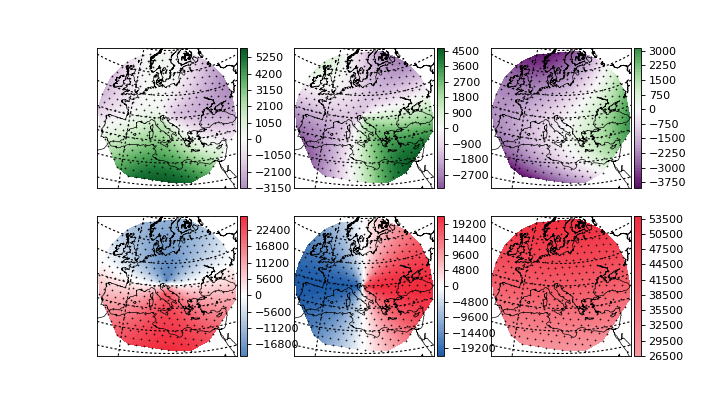

/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


In [12]:
field_plots.component_residual_plot(theta_r, phi_r, theta_0, theta_c, phi_c, (Bx_dip_r, By_dip_r, Bz_dip_r),
                                    (Rx_r, Ry_r, Rz_r), dots=True)

#### segunda cosa (modelizar la cosa)

In [95]:
ms = numpy.arange(0, 7);
#roots = scha.degree(ms, theta0 = theta_0d, max_k = 4)
roots = scha.degree(ms, theta0 = theta_0nice, max_k = 4)
k, m, n = scha.join_roots(roots)

k, m, n = numpy.array((k, m, n))
km_even = ((k-numpy.abs(m)) % 2 == 0) & (k <= 4)
#km_odd = ((k-numpy.abs(m)) % 2 != 0) & (k <= 7)
#m_mehler = numpy.array((0, 1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7))
m_mehler= numpy.array((0, 1, -1, 2, -2))
#m_mehler = numpy.array((0, 1, -1))
#m_mehler = numpy.array(())

k_even, m_even, n_even = k[km_even], m[km_even], n[km_even]
#k_odd, m_odd, n_odd = k[km_odd], m[km_odd], n[km_odd]


In [14]:
import rscha

In [15]:
gpr=rscha.invert_xyz(theta_r, phi_r, Rx_r, Ry_r, Rz_r, (k_even, m_even, n_even), m_mehler, theta_0d)
#gpr=rscha.invert_xyz(theta_r, phi_r, Rx_r, Ry_r, Rz_r, (k, m, n), m_mehler, theta_0d)
Rx_inv, Ry_inv, Rz_inv = rscha.synth_field((k_even, m_even, n_even), m_mehler, gpo, theta_r, phi_r, theta_0d)
#Rx_inv, Ry_inv, Rz_inv = rscha.synth_field((k, m, n), m_mehler, gpr, theta_r, phi_r, theta_0d)
#Rx_inv, Ry_inv, Rz_inv = rscha.synth_field(((),(),()), (m_mehler[3],), gpr[len(k)+3:], theta_r, phi_r, theta_0d)

NameError: name 'gpo' is not defined

15.0 45.0


<IPython.core.display.Javascript object>


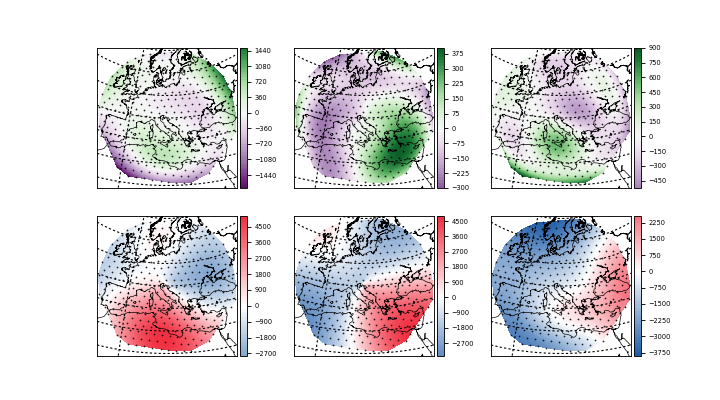

/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


In [248]:
field_plots.component_residual_plot(theta_r, phi_r, theta_0, theta_c, phi_c,
                                    (Rx_inv, Ry_inv, Rz_inv),
                                    (Rx_inv - Rx_r, Ry_inv - Ry_r, Rz_inv - Rz_r),
                                    dots=True)

In [230]:
def residuals(gp, kmn_leg, m_meh, thetav, phiv, theta_0, X_o, Y_o, Z_o):
    sxyz = numpy.concatenate(rscha.synth_field(kmn_leg, m_meh, gp, thetav, phiv, theta_0))
    return (sxyz - numpy.concatenate((X_o, Y_o, Z_o)))

In [245]:
g_init = numpy.zeros(len(k_even)+len(m_mehler)); g_init[0] = -30000
gpo = scipy.optimize.leastsq(residuals, g_init, args=((k_even, m_even, n_even), m_mehler,
                                                      theta_r, phi_r, theta_0d, Rx_r, Ry_r, Rz_r))[0]

###### wow realmente es la misma cosa, que sorprendencia (buena claro)

In [16]:
import trig; importlib.reload(trig)


<module 'trig' from '/home/josecper/Programs/python/trig.py'>

In [97]:
def residuals_dif(gp, kmn_leg, m_meh, thetav, phiv, theta_0, D_o, I_o, F_o):
    sxyz = rscha.synth_field(kmn_leg, m_meh, gp, thetav, phiv, theta_0)
    sD, sI, sF, sH = xyzfield.xyz2difh(*sxyz)
    return numpy.concatenate((trig.mindiff(sD, D_o), trig.mindiff(sI, I_o), (sF-F_o)/sF))
    #return numpy.concatenate((sD-D_o, sI-I_o, (sF-F_o)/sF))

In [61]:
#esto no parece muy buena idea la verdad lol
#D_r, I_r, F_r, H_r = xyzfield.xyz2difh(Rx_r, Ry_r, Rz_r)

In [98]:
g_init = numpy.zeros(len(k_even)+len(m_mehler)); g_init[0] = 958
gpodif = scipy.optimize.least_squares(residuals_dif, g_init, args=((k_even, m_even, n_even), m_mehler,
                                                                  theta_r, phi_r, theta_0nice, D_r, I_r, F_r),
                                      verbose=2).x

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0244e+03                                    1.03e+11    
       1              2         1.0013e+03      1.02e+03       7.00e+02       3.29e+01    
       2              3         6.4561e+02      3.56e+02       9.58e+02       4.61e+00    
       3              4         2.9124e+02      3.54e+02       9.58e+02       1.33e+00    
       4              5         1.3288e+02      1.58e+02       1.92e+03       2.50e-01    
       5              6         3.2869e+01      1.00e+02       3.83e+03       2.01e-01    
       6              7         5.0381e+00      2.78e+01       7.11e+03       3.22e-01    
       7              8         1.8202e+00      3.22e+00       2.47e+02       1.50e-01    
       8              9         1.5859e+00      2.34e-01       6.89e+01       1.56e-01    
       9             10         1.4845e+00      1.01e-01       2.14e+02       1.06e-02    

In [99]:
gpodif

array([  1.20961960e+03,  -5.09254256e+01,  -6.97067317e+02,
        -1.09874021e+02,   4.21029360e+02,  -5.55040038e+01,
        -8.13400208e+01,   3.22369922e+01,  -6.56142313e+01,
        -7.90581538e+00,   3.55600553e+00,  -2.33432574e+01,
         4.08643958e+00,   2.84721053e+01,   9.96966172e-01,
         4.85582144e+02,  -2.05673408e+02,  -4.65216536e+01,
         5.83131643e+01,   4.04091442e+00])

In [100]:
residuals_dif(g_init, (k_even, m_even, n_even), m_mehler, theta_r, phi_r, theta_0d, D_r, I_r, F_r)

array([  2.57048439e+00,   2.67454473e+00,   2.78624824e+00,
         2.90783760e+00,   3.03686476e+00,  -3.11251464e+00,
        -2.97667950e+00,  -2.84318888e+00,  -2.71039286e+00,
         2.45393098e+00,   2.55457212e+00,   2.67185626e+00,
         2.25033496e+00,   2.79995137e+00,   2.93989501e+00,
         2.32650105e+00,   3.08647885e+00,  -3.04532834e+00,
        -2.89595302e+00,   2.42175458e+00,  -2.74967636e+00,
        -2.46372342e+00,  -2.60780409e+00,   2.53585569e+00,
         2.11083711e+00,   2.66982230e+00,   2.82073129e+00,
         2.17586072e+00,   2.98442730e+00,  -3.12860649e+00,
         2.26328767e+00,  -2.95826253e+00,  -2.79299646e+00,
        -2.33867361e+00,  -2.63501004e+00,  -2.48394640e+00,
         2.37466253e+00,   2.51497370e+00,   1.95780113e+00,
         2.67107829e+00,   2.00748688e+00,   2.84935385e+00,
         3.04065015e+00,   2.08109578e+00,  -3.04647589e+00,
        -2.85759038e+00,  -2.19865123e+00,  -2.67862000e+00,
        -2.34856378e+00,

es curioso esto, parece converger a una cosa muy parecida aunque lentamente

15.0 45.0


<IPython.core.display.Javascript object>


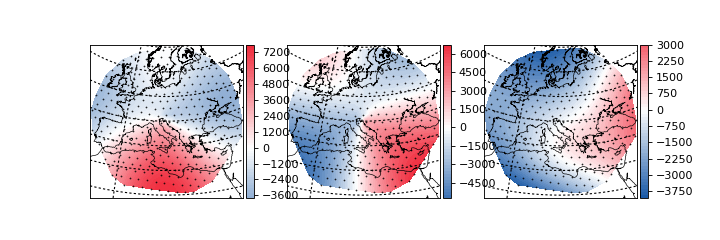

/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


In [101]:
Rx_idif, Ry_idif, Rz_idif = rscha.synth_field((k_even, m_even, n_even), m_mehler, gpodif,
                                              theta_r, phi_r, theta_0d)
field_plots.component_residual_plot(theta_r, phi_r, theta_0, theta_c, phi_c,
                                    (Rx_idif, Ry_idif, Rz_idif),
                                    dots=True)

después de mucho sufrimiento, parece que el rscha es un poco basura con $r=a$ (necesitamos el campo externo sí o sí), por lo que hay que transformar desde coordenadas geodésicas

In [22]:
a_ellip = 6378.137; b_ellip = 6356.752

r_geo, theta_geo, phi_geo = trig.geo2sph(thetav, phiv)

<IPython.core.display.Javascript object>


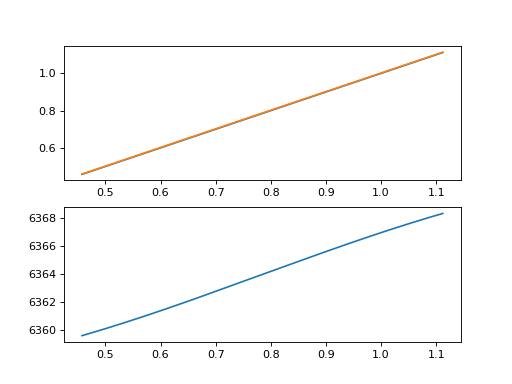

In [25]:
fig, (ax1, ax2) = pyplot.subplots(2,1)

ax1.plot(thetav, thetav)
ax1.plot(thetav, theta_geo)
ax2.plot(thetav, r_geo)

In [52]:
kmn_in = k_even,m_even,n_even

In [36]:
r, theta_geo_r, phi_geo_r = scha.rotate_coords(1.0, theta_geo, phi_geo, rot_mat)

In [53]:
kmn_ext = k_even[1:], m_even[1:], n_even[1:]

In [54]:
gcoefs_in = numpy.zeros_like(kmn_in[0]); gcoefs_in[0] = 200

In [55]:
gcoefs_ext = numpy.zeros_like(kmn_ext[0])

In [68]:
import rscha_r; importlib.reload(rscha_r)

<module 'rscha_r' from '/home/josecper/Programs/python/rscha_r.py'>

In [71]:
def residuals_dif_r (gp, kmn_in, kmn_ext, m_meh, rv, thetav, phiv, theta_0, D_o, I_o, F_o):
    gp_in = gp[:len(kmn_in[0])]
    gp_ext = gp[len(kmn_in[0]):len(kmn_in[0])+len(kmn_ext[0])]
    gp_m = gp[-len(m_meh):]
    
    sxl, syl, szl = rscha_r.leg_field(kmn_in, kmn_ext, gp_in, gp_ext, rv, thetav, phiv)
    sxm, sym, szm = rscha_r.mehler_field(m_mehler, gp_m, rv, thetav, phiv, theta_0d)
    sxyz = sxl+sxm, syl+sym, szl+szm
    sD, sI, sF, sH = xyzfield.xyz2difh(*sxyz)
    return numpy.concatenate((trig.mindiff(sD, D_o), trig.mindiff(sI, I_o), (sF-F_o)/sF))

In [85]:
m_mehler = (0, 1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6)

In [86]:
g_init = numpy.concatenate((gcoefs_in, gcoefs_ext, numpy.zeros_like(m_mehler)))
gpodif = scipy.optimize.least_squares(residuals_dif_r, g_init, args=(kmn_in, kmn_ext, m_mehler, r_geo,
                                                                     theta_geo_r, phi_geo_r, theta_0d,
                                                                     D_r, I_r, F_r),
                                      verbose=2).x

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.6176e+04                                    1.03e+11    
       1              2         1.1573e+04      3.46e+04       1.89e+02       1.04e+05    
       2              3         3.1783e+03      8.39e+03       2.00e+02       3.63e+02    
       3              4         1.0338e+03      2.14e+03       4.00e+02       7.35e+01    
       4              5         4.2983e+02      6.04e+02       8.00e+02       1.36e+01    
       5              6         2.2248e+02      2.07e+02       1.60e+03       4.57e+00    
       6              7         9.5024e+01      1.27e+02       3.20e+03       1.67e+00    
       7              8         1.3693e+01      8.13e+01       6.40e+03       4.05e-01    
       8              9         7.8866e+00      5.81e+00       1.28e+04       9.59e-01    
       9             10         1.8833e+00      6.00e+00       1.28e+04       1.38e-01    

In [87]:
gp_in = gpodif[:len(kmn_in[0])]
gp_ext = gpodif[len(kmn_in[0]):len(kmn_in[0])+len(kmn_ext[0])]
gp_m = gpodif[-len(m_mehler):]

sxl, syl, szl = rscha_r.leg_field(kmn_in, kmn_ext, gp_in, gp_ext, r_geo, theta_geo_r, phi_geo_r)
sxm, sym, szm = rscha_r.mehler_field(m_mehler, gp_m, r_geo, theta_geo_r, phi_geo_r, theta_0d + 0.1)
sxyz = sxl+sxm, syl+sym, szl+szm

15.0 45.0


<IPython.core.display.Javascript object>


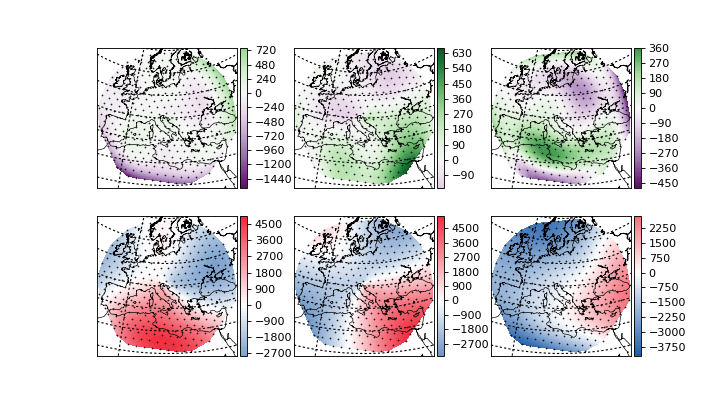

/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


In [90]:
field_plots.component_residual_plot(theta_geo_r, phi_geo_r, theta_0, theta_c, phi_c,
                                    sxyz,
                                    (sxyz[0] - Rx_r, sxyz[1] - Ry_r, sxyz[2] - Rz_r),
                                    dots=True)